### setup: alpha=0.8, 70% CVaR, sample size=2000

In [128]:
# Experimental setup arguments

class args:
    alpha = 0.8         # risk control level
    tightness = 0.24    # tightness parameter, may throw error if too low
    delta = 0.1         # failure probability or confidence parameter

    tau = 1            # safety parameter
    # L = 5              # Lipschitz constant

    # gamma = 0.001        # sensitivity constant, must be <= tau / L from the theory

    N = 2000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    ell_max = 1.0

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # M             # upper bound on the PDF of the initial data distribution

In [19]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [21]:
import os
os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [23]:
from collections import Counter
from sklearn.model_selection import train_test_split
from data_prep import load_data

# Set random seed for reproducibility
np.random.seed(42)

# Load data
path_to_csv_file = './cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

# Report full feature dimension
d = X_all.shape[1] - 1
print('d =', d)

# Show class distribution in the full dataset
print("Class distribution in full dataset:", Counter(Y_all))

# Identify indices for each class
idx_0 = np.where(Y_all == 0)[0]
idx_1 = np.where(Y_all == 1)[0]

# Choose equal number of samples from each class
n_samples_per_class = min(len(idx_0), len(idx_1), 1500)  # capped at 1000 per class
idx_balanced = np.concatenate([
    np.random.choice(idx_0, size=n_samples_per_class, replace=False),
    np.random.choice(idx_1, size=n_samples_per_class, replace=False),
])

# Shuffle balanced indices
np.random.shuffle(idx_balanced)

# Create balanced training set
X_train = X_all[idx_balanced]
Y_train = Y_all[idx_balanced]

# Remaining indices (not used in training) go to calibration/test pool
idx_remaining = np.setdiff1d(np.arange(len(Y_all)), idx_balanced)
X_temp = X_all[idx_remaining]
Y_temp = Y_all[idx_remaining]

# Show class distributions
print("Class distribution in training set:", Counter(Y_train))
print("Class distribution in calibration/test set:", Counter(Y_temp))

# Clean up
del X_all, Y_all

d = 10
Class distribution in full dataset: Counter({0: 8500, 1: 6500})
Class distribution in training set: Counter({1: 1500, 0: 1500})
Class distribution in calibration/test set: Counter({0: 7000, 1: 5000})


In [25]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[ 0.1136458  -0.3417563   1.95336523  0.00992734 -0.77206297  0.03066799
   1.98923754  0.09548938  0.53777071  0.10606014 -0.22333601]]


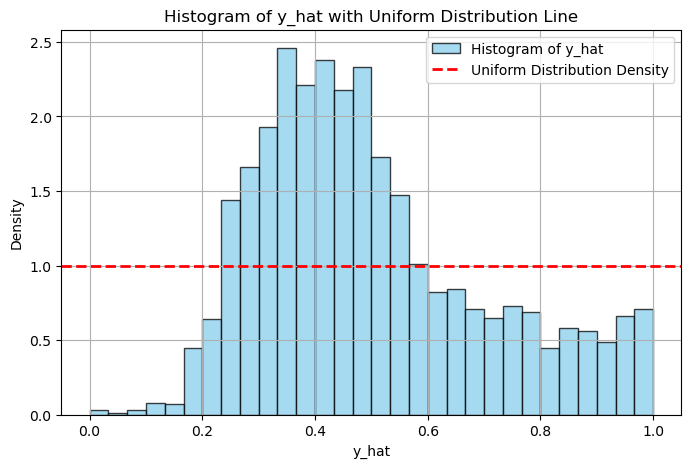

In [27]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_train)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute M: Upper bound of the PDF
M= counts.max()

In [98]:
def psi_var(beta):
    def fn(p):
        return 1.0 if np.isclose(p, beta, atol=1e-4) else 0.0
    return fn

def psi_cvar(beta):
    def fn(p):
        return 1.0 / (1.0 - beta) if p >= beta else 0.0
    return fn

def psi_var_interval(beta_min, beta_max):
    def fn(p):
        return 1.0 / (beta_max - beta_min) if beta_min <= p <= beta_max else 0.0
    return fn

psi_fn = psi_cvar(0.7)

# bound for weighting function
# psi_var: 1/(1-beta)
# psi_var_interval: 1/(beta_max-beta_min)

In [100]:
import numpy as np
from scipy.stats import norm

# DKW bound function
def DKW_bound(T):
    delta_prime = args.delta/T
    return np.sqrt(np.log(2 / delta_prime) / (2 * args.N))

In [102]:
import scipy.stats as stats

def calc_clt_bound(T, delta_prime, N, emp_risk, loss_max=1.0, beta=0.9):
    z = norm.ppf(1 - delta_prime / 2)
    variance = emp_risk * (1 - emp_risk) / (1 - beta)**2
    return z * np.sqrt(variance) / np.sqrt(N)

def clt_bound(T, n, alpha, beta, num_grid=100):
    delta_prime = args.delta / T
    emp_risks = np.linspace(0, alpha * (1 - beta), num_grid)
    
    widths = np.array([
        calc_clt_bound(T, delta_prime, n, r, beta=beta) for r in emp_risks
    ])
    upper_bounds = emp_risks + widths

    valid_widths = widths[upper_bounds <= alpha]
    return float(np.max(valid_widths)) if len(valid_widths) > 0 else 0.0

In [130]:
# Search for optimal T
def find_optimal_T(psi_fn, alpha, max_T=1000):
    best_T = None
    best_result = None

    for T in range(1, max_T + 1):
        c_delta = clt_bound(T, args.N, args.alpha, beta=0.7)
        delta_lambda = (args.tightness - 2 * c_delta) / (2 * args.tau)

        if delta_lambda <= 0 or delta_lambda >= 1:
            continue

        if T >= args.lambda_max / delta_lambda:
            best_T = T
            break
            
    return best_T, delta_lambda

# Run the optimization
optimal_T, delta_lambda = find_optimal_T(psi_fn, args.alpha)
print(optimal_T, delta_lambda)

44 0.022843922699673558


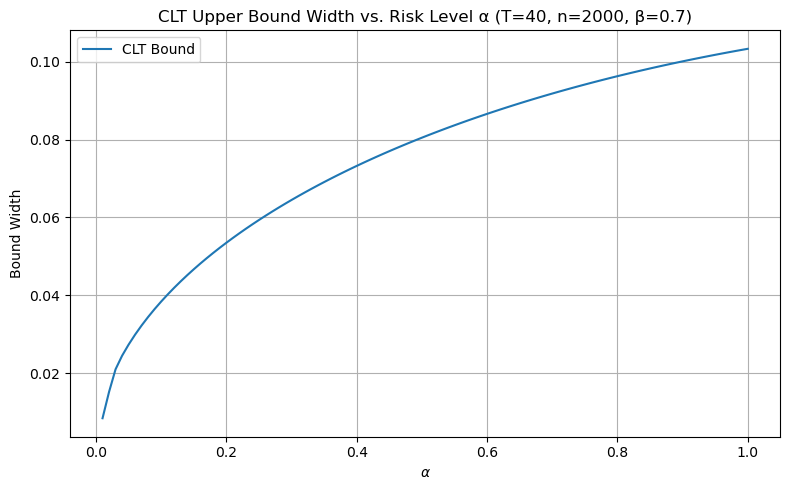

In [136]:
import matplotlib.pyplot as plt


# Parameters
T = 40
n = 2000
beta = 0.7
alpha_values = np.linspace(0.01, 1.0, 100)
bounds = [clt_bound(T, n, alpha, beta=beta) for alpha in alpha_values]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, bounds, label="CLT Bound")
plt.xlabel(r'$\alpha$')
plt.ylabel('Bound Width')
plt.title(f'CLT Upper Bound Width vs. Risk Level α (T={T}, n={n}, β={beta})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Experiment

In [138]:
def compute_qbrm(Y, Y_proba, threshold, psi_fn, num_grid=10000):
    # Binary loss: false negative (Type II)
    losses = (Y == 1) * (Y_proba < 1 - threshold)
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)
    if n == 0:
        return 0.0

    # Create a quantile grid
    p_grid = np.linspace(0, 1, num_grid)
    idxs = (p_grid * n).astype(int)
    idxs = np.clip(idxs, 0, n - 1)

    # Empirical quantile function (inverse CDF)
    quantile_vals = sorted_losses[idxs]

    # Evaluate psi function on grid
    weights = np.array([psi_fn(p) for p in p_grid])
    weights /= np.sum(weights)  # Normalize to integrate to 1

    # Riemann sum
    risk = np.sum(weights * quantile_vals)

    return risk

def modify(Y_proba, threshold):
    shift = args.gamma / M
    condition = (1 - threshold) < (Y_proba - shift)

    Y_proba_new = Y_proba.copy()
    Y_proba_new[~condition] -= shift
    Y_proba_new = np.clip(Y_proba_new, 0, 1)

    return Y_proba_new

In [140]:
def binary_search_solver(objective, lam_low, lam_high, tol=1e-6, max_iter=100):
    if objective(lam_low) <= 0:
        return lam_low
    
    if objective(lam_high) > 0:
        raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

    for _ in range(max_iter):
        mid = (lam_low + lam_high) / 2.0
        if objective(mid) <= 0:
            lam_high = mid
        else:
            lam_low = mid
        if lam_high - lam_low < tol:
            break
    return lam_high

In [152]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, psi_fn, verbose=False):
    args.T, args.delta_lambda = find_optimal_T(psi_fn, args.alpha)
    #args.bound = DKW_bound(args.T)
    args.bound = clt_bound(T, args.N, args.alpha, beta=0.7)
     
    # Initialization
    thresh = args.lambda_max
    threshes = [thresh]

    # Metrics
    qbrm_at_lambda_t = []
    qbrm_at_lambda_tp1 = []

    iters = tqdm(range(1, args.T + 1)) if verbose else range(1, args.T + 1)
    # args.N = 1000 Number of samples per iteration

    ### === NEW PART: prepare global indices without replacement ===
    total_size = len(Y)
    #assert n_sample * args.T <= total_size, "Not enough samples for no-replacement sampling! Reduce T or sample size."
    #all_indices = np.random.permutation(total_size)  # Shuffle once
    #pointer = 0  # Pointer to track where we are


    for t in iters:
        # Deploy threshold
        Y_proba_t = modify(Y_proba, thresh)

        # === Take a fresh batch without global repeats ===
        #idx = all_indices[pointer: pointer + args.N]
        #pointer += args.N  # Move pointer for next iteration

        #Y_sample = Y[idx]
        #Y_proba_sample = Y_proba_t[idx]

        # === Take a fresh batch WITH replacement ===
        idx = np.random.choice(total_size, size=args.N, replace=True)

        Y_sample = Y[idx]
        Y_proba_sample = Y_proba_t[idx]

        # Calculate qbrm
        qbrm_t = float(compute_qbrm(Y_sample, Y_proba_sample, thresh, psi_fn))
        qbrm_at_lambda_t.append(qbrm_t)

        # Update threshold
        func = lambda nt: np.mean(compute_qbrm(Y_sample, Y_proba_sample, nt, psi_fn)) + args.tau * (thresh - nt) + args.bound - args.alpha
        mid_thresh = binary_search_solver(func, 0, 1)
        new_thresh = min(mid_thresh, thresh)

        # Evaluate new threshold
        qbrm_tp1 = float(compute_qbrm(Y_sample, Y_proba_sample, new_thresh, psi_fn))
        qbrm_at_lambda_tp1.append(qbrm_tp1)

        if new_thresh > thresh - args.delta_lambda:
            threshes.append(new_thresh)
            stopping_iter = t
            break

        thresh = new_thresh
        threshes.append(thresh)

    return {
        "Stopping iteration": stopping_iter,
        "qbrm_at_lambda_t": qbrm_at_lambda_t,
        "qbrm_at_lambda_tp1": qbrm_at_lambda_tp1,
        "threshes": threshes
    }

### Run

In [155]:
X_cal, X_test, Y_cal, Y_test = train_test_split(
    X_temp, Y_temp, train_size=10000, random_state=42
)
Y_proba = model.predict_proba(X_cal)[:,1]

### plot 1: change gamma, i.e. magnitude of distribution shift

In [158]:
gammas = [0.001, 0.01, 0.02, 0.1, 0.2, 0.5]
results_1 = {}

for gamma in gammas:
    args.gamma = gamma

    # Run PRC
    output = run_trajectory(Y_cal, Y_proba, psi_fn)

    results_1[gamma] = {
        "qbrm_at_lambda_t": output["qbrm_at_lambda_t"],
        "qbrm_at_lambda_tp1": output["qbrm_at_lambda_tp1"],
        "threshes": output["threshes"],
    }

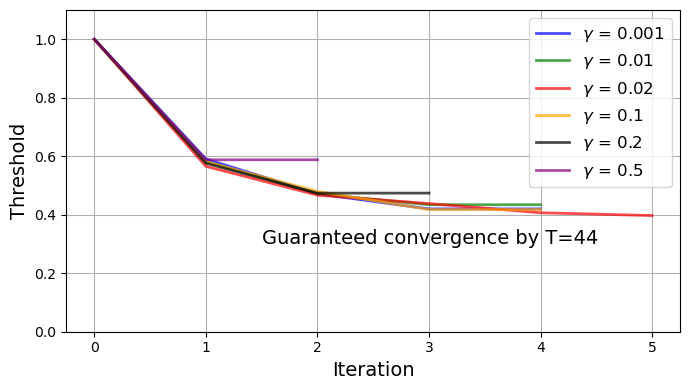

In [160]:
plt.figure(figsize=(7, 4))
plt.ylim(0, args.lambda_max)

colors = ['blue', 'green', 'red', 'orange', 'black', 'purple', 'brown']

for gamma, color in zip(gammas, colors):
    plt.plot(results_1[gamma]["threshes"], label=rf"$\gamma$ = {gamma}", color=color, alpha=0.7, linewidth=2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Threshold', fontsize=14)
plt.ylim(0, 1.1)
plt.text(1.5, 0.3, f"Guaranteed convergence by T={args.T}", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

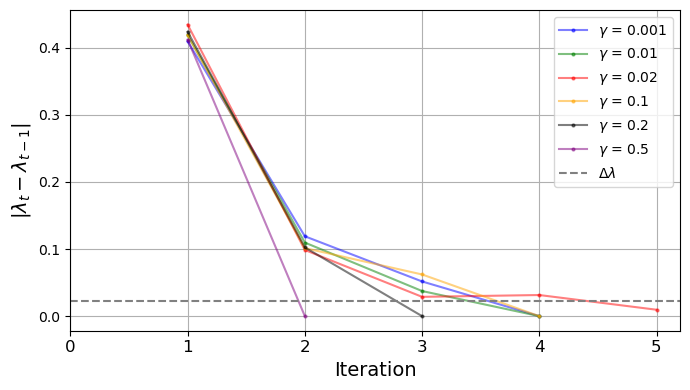

In [162]:
plt.figure(figsize=(7, 4))

num_iters = 0

for gamma, color in zip(gammas, colors):
    threshes = results_1[gamma]["threshes"]
    diffs = [np.abs(threshes[i] - threshes[i - 1]) for i in range(1, len(threshes))]
    if len(diffs) > num_iters:
        num_iters = len(diffs)
    
    # Normalize to start from 1
    if diffs[0] > 0:
        normalized_diffs = [diff / diffs[0] for diff in diffs]
        normalized_delta_lambda = args.delta_lambda / diffs[0]  # Normalize delta_lambda
        plt.plot(range(1, len(threshes)), diffs, marker='o', markersize=2,
                 label=rf"$\gamma$ = {gamma}", color=color, alpha = 0.5)

plt.axhline(y=args.delta_lambda, color='gray', linestyle='--', linewidth=1.5, label=rf"$\Delta\lambda$")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'$|\lambda_t - \lambda_{t-1}|$', fontsize=14)
plt.xticks(ticks=range(num_iters + 1), labels=[str(i) for i in range(num_iters + 1)], fontsize=12)
#plt.ylim(0,1.1)
#plt.title('Normalized Squared Threshold Differences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

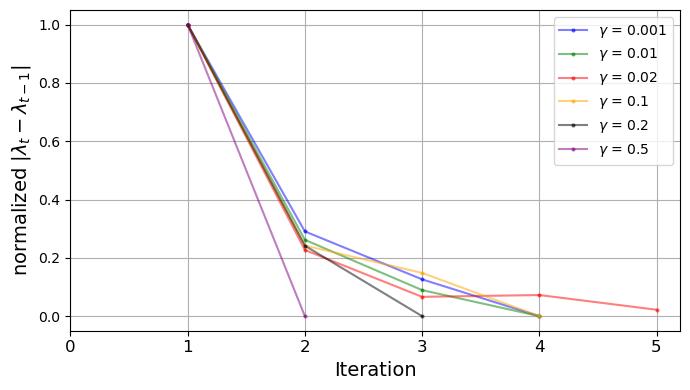

In [164]:
plt.figure(figsize=(7, 4))

for gamma, color in zip(gammas, colors):
    threshes = results_1[gamma]["threshes"]
    # Compute squared diffs between successive thresholds
    diffs = [np.abs(threshes[i] - threshes[i - 1]) for i in range(1, len(threshes))]
    
    # Normalize to start from 1
    if diffs[0] > 0:
        normalized_diffs = [diff / diffs[0] for diff in diffs]
        normalized_delta_lambda = args.delta_lambda / diffs[0]  # Normalize delta_lambda
        plt.plot(range(1, len(threshes)), normalized_diffs, marker='o', markersize=2,
                 label=rf"$\gamma$ = {gamma}", color=color, alpha = 0.5)

#plt.axhline(y=args.delta_lambda, color='gray', linestyle='--', linewidth=1.5, label=rf"$\Delta\lambda$")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'normalized $ |\lambda_t - \lambda_{t-1}|$', fontsize=14)
plt.xticks(ticks=range(num_iters + 1), labels=[str(i) for i in range(num_iters + 1)], fontsize=12)
#plt.ylim(0,1.1)
#plt.title('Normalized Squared Threshold Differences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### plot 2: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t+1})$  (avg over 1000 trajectories+err bar). 

In [190]:
args.gamma = 0.02

In [198]:
num_runs = 1000
all_qbrm_tp1 = []
all_qbrm_t = []

for seed in range(num_runs):
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]
    
    results_2 = run_trajectory(Y_cal, Y_proba_cal, psi_fn)

    all_qbrm_tp1.append(results_2["qbrm_at_lambda_tp1"])
    all_qbrm_t.append(results_2["qbrm_at_lambda_t"])

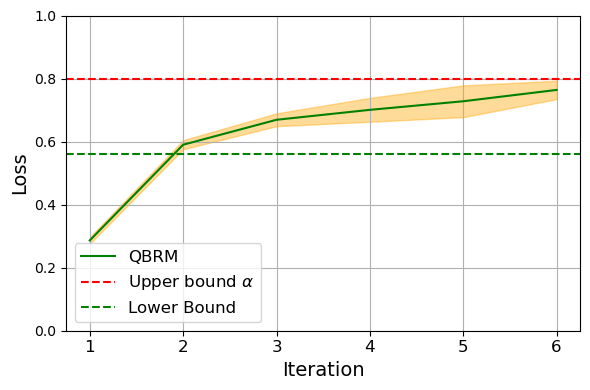

In [200]:
max_len = max(len(l) for l in all_qbrm_tp1)

err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_qbrm_tp1
])

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  
err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

plt.figure(figsize=(6, 4))

# Plot mean trajectories
#plt.plot(loss_mean, color='red', label='Empirical Loss')
plt.plot(err_mean, color='green', label='QBRM')

# Confidence bands
#plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='b', alpha=0.4)
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=0.4)

# Reference lines
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Set x-axis to show 1-based iteration numbers
num_iters = len(err_mean)
plt.xticks(ticks=range(num_iters), labels=[str(i+1) for i in range(num_iters)], fontsize=12)
plt.ylim(0, 1.0)
plt.legend(fontsize=12)
#plt.title("One-Step Lookahead Risk & Error (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

### plot 3: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t})$ (avg over 1000 trajectories+err bar)

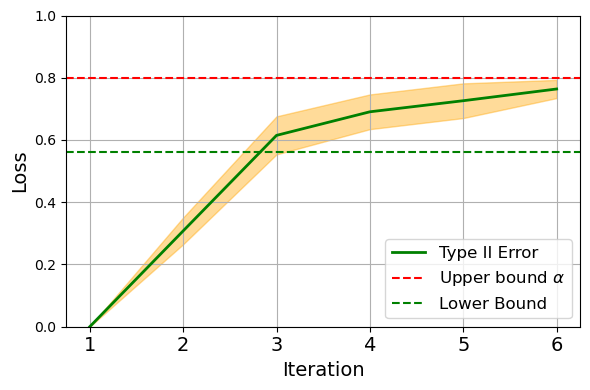

In [203]:
err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_qbrm_t
])

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  # for ~90% confidence
#loss_upper = loss_mean + z * loss_std
#loss_lower = loss_mean - z * loss_std

err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

# Plotting
plt.figure(figsize=(6, 4))

# Mean curves
# plt.plot(loss_mean, color='red', label='Empirical Loss', linewidth=2)      
plt.plot(err_mean, color='green', label='Type II Error', linewidth=2)         

# Confidence bands
# plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='blue', alpha=0.4)  
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=0.4)    

# Reference bounds
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

# Labels and layout
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Set x-axis to show 1-based iteration numbers
num_iters = len(err_mean)
plt.xticks(ticks=range(num_iters), labels=[str(i+1) for i in range(num_iters)], fontsize=14)
plt.ylim(0, 1.0)
plt.legend(fontsize=12)
#plt.title("Performative Risk & Error at λ_t (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot 4: We get for lambda_T actual value +- err and upper (alpha) and lower bound $E_{D(\lambda_T)}l (\lambda_T)$ 

In [206]:
def evaluate_qrc_over_seeds(X_cal, Y_cal, X_test, Y_test, num_runs=1000):
    all_test_errors = []
    all_final_thresholds = []
    all_stopping_iters = []

    for seed in range(num_runs):
        # Step 2: Predict probabilities
        Y_proba_cal = model.predict_proba(X_cal)[:, 1]
        Y_proba_test = model.predict_proba(X_test)[:, 1]

        # Step 3: Run QRC
        results_3 = run_trajectory(Y_cal, Y_proba_cal, psi_fn)
        final_thresh = results_3["threshes"][-1]
        stopping_iter = results_3["Stopping iteration"]
        all_stopping_iters.append(stopping_iter)
        
        # Step 4: Evaluate on test set (simulate D(λ_T) using final_thresh) 
        Y_proba_test_mod = modify(Y_proba_test, final_thresh)

        # Step 5: Evaluate test loss and error under D(λ_T)
        test_error = float(compute_qbrm(Y_test, Y_proba_test_mod, final_thresh, psi_fn))

        # Step 6: Store results
        #all_test_losses.append(test_loss)
        all_test_errors.append(test_error)
        all_final_thresholds.append(final_thresh)

    # Compute statistics and bound
    #losses = np.array(all_test_losses)
    errors = np.array(all_test_errors)

    return {
    #"losses": losses,
    "errors": errors,
    "thresholds": all_final_thresholds,
    "stopping_iters": all_stopping_iters
}

In [208]:
results_3 = evaluate_qrc_over_seeds(X_cal, Y_cal, X_test, Y_test)

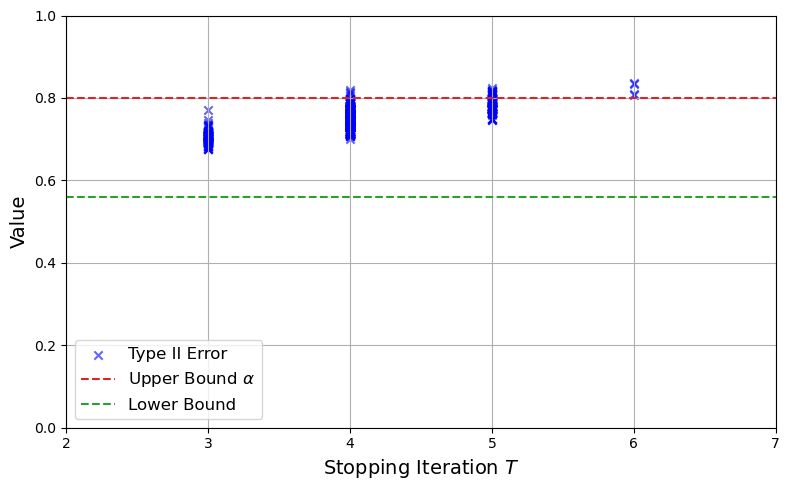

Percentage of Type II Error inside bounds: 97.30%


In [210]:
# Extract values
T_vals = np.array(results_3["stopping_iters"])
#loss_vals = np.array(results_3["losses"])
error_vals = np.array(results_3["errors"])

plt.figure(figsize=(8, 5))

# Plot T vs Loss
# plt.scatter(T_vals, loss_vals, color='blue', label='Loss', alpha=0.6, marker='o')

# Plot T vs Error
plt.scatter(T_vals, error_vals, color='blue', label='Type II Error', alpha=0.6, marker='x')

# Plot upper and lower bound
plt.axhline(args.alpha, linestyle='--', color='#d62728', label=r'Upper Bound $\alpha$', linewidth=1.5)  # red
plt.axhline(args.alpha - args.tightness, linestyle='--', color='#2ca02c', label=r'Lower Bound', linewidth=1.5)  # green

plt.xlabel("Stopping Iteration $T$", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlim(2, 7)
plt.ylim(0, 1)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
#plt.title("Scatter Plot of Loss and Type II Error vs Stopping Iteration", fontsize=14)
plt.show()

# Define bounds
upper_bound = args.alpha
lower_bound = args.alpha - args.tightness

# Calculate percentage inside the bounds
# loss_inside = np.logical_and(loss_vals >= lower_bound, loss_vals <= upper_bound)
error_inside = np.logical_and(error_vals >= lower_bound, error_vals <= upper_bound)

# loss_inside_percentage = 100 * np.mean(loss_inside)
error_inside_percentage = 100 * np.mean(error_inside)

# print(f"Percentage of Loss inside bounds: {loss_inside_percentage:.2f}%")
print(f"Percentage of Type II Error inside bounds: {error_inside_percentage:.2f}%")